In [368]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, log_loss, make_scorer
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_regression

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from threading import Lock

import itertools

import os
import re

from typing import Iterable, Callable, Union, Optional, List, Tuple

In [407]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ERA = "ERA5"

In [408]:
class Data:
    
    @staticmethod
    def load(path) -> pd.DataFrame:
        df = pd.read_csv(path, names=["date", "series"])

        # Set Date as Index
        df["date"] = pd.DatetimeIndex(df["date"])
        df = df.set_index("date")

        # Remove Hour Offset, if any
        df.index -= pd.Timedelta(df.index[0].hour, 'h')

        return df
    
class Labels:
    
    LABELS_PATH = os.path.join(DATA_ROOT, f'heatwave_{ERA}.csv')
    
    def __init__(self, transform: Optional[pd.DataFrame] = None, binary: bool = False):
        self._transform = transform
        self._binary = binary
        
        self._labels = Data.load(self.LABELS_PATH)
        self._std = float(self._labels.std())
        self._years = np.unique(self.index.year)
        
        if binary:
            self._labels = (self._labels > self._std).astype(np.int)
        
        self._transformed_labels = self._labels - self._transform.values if (self._transform is not None) else self._labels
        
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._labels.index
    
    @property
    def years(self) -> np.ndarray:
        return self._years
    
    @property
    def events(self) -> pd.DataFrame:
        return self._labels > self.std
    
    @property
    def std(self) -> float:
        return self._std
    
    @property
    def transform(self) -> Optional[pd.DataFrame]:
        return self._transform
    
    @property
    def binary(self) -> bool:
        return self._binary
        
    def get(self, transformed=True) -> pd.DataFrame:
        return self._transformed_labels if transformed else self._labels
    
    def plot(self, year: int):
        heatwave = self.get(False)["series"][str(year)]
        
        # Create Big Figure
        plt.rcParams['figure.figsize'] = [15, 5]
        
        # Plot Heatwave
        plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
        plt.plot(heatwave, c="black", label="T95")
        plt.axhline(self.std, c="gray", linestyle="--", label="T95 Mean + STD")
        plt.fill_between(heatwave.index, self.std, heatwave, where=heatwave > self.std,
                         interpolate=True, color="crimson", label="Hot Days")

        plt.xlabel("Date")
        plt.ylabel("Heatwave (STD)")
        plt.ylim(-3, 3)
        plt.legend()

        
class Features:
    STATIC_FEATURE_ROOT = os.path.join(DATA_ROOT, 'features', ERA)
    DYNAMIC_FEATURE_ROOT = os.path.join(DATA_ROOT, 'precursor', ERA)
    
    def __init__(self, index: pd.DatetimeIndex, precursor: int, selection: Optional[List[str]] = None, dynamic_set: Union[int, str] = 'timeseries_robwghts'):
        self._index = index
        self._precursor = precursor
        
        self._selection = selection
        self._dynamic_set = dynamic_set
        
        self._dynamic_path = os.path.join(self.DYNAMIC_FEATURE_ROOT, dynamic_set)
        self._years = [tuple(int(year) for year in re.findall('\d{4}', path)) for path in os.listdir(self._dynamic_path) if re.match(r'testyr\[(.+?)]_50.csv', path)]
        
        self.static_features = self._load_static_features()
        self.dynamic_features = {years: self._load_dynamic_features(years) for years in self.years}
        
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._index
    
    @property
    def years(self) -> List[List[int]]:
        return self._years

    @property
    def precursor(self) -> int:
        return self._precursor
    
    def get(self, year: int) -> pd.DataFrame:
        return pd.concat([self.static_features, self.dynamic_features[year]], axis=1)
        
    def _load_static_features(self) -> pd.DataFrame:
        features = pd.DataFrame(index=self.index)
        
        for path in os.listdir(self.STATIC_FEATURE_ROOT):
            name, ext = os.path.splitext(path)
            
            if ext == '.csv':
                if not self._selection or name in self._selection:
                    feature = Data.load(os.path.join(self.STATIC_FEATURE_ROOT, path))
                    
                    if self._selection:
                        
                        windows, lags = self._selection[name]
                        
                        for window, lag in zip(windows, lags):
                            features[f"{name}-{window}-{lag}"] = feature.rolling(window).mean().loc[self.index - pd.Timedelta(lag, 'D')].values
                    else:
                        features[name] = feature.loc[self.index].values
                
        return features.astype(np.float64)
    
    def _load_dynamic_features(self, years) -> pd.DataFrame:
        features = pd.DataFrame(index=self.index)
        
        years_str = ', '.join([str(year) for year in years])
        
        df = pd.read_csv(os.path.join(self._dynamic_path, f'testyr[{years_str}]_{self.precursor}.csv'))
        
        # Set Date as Index
        df['date'] = pd.DatetimeIndex(df['date'])
        df = df.set_index('date')
        
        # Remove Hour Offset, if any
        df.index -= pd.Timedelta(df.index[0].hour, 'h')
        
        if self._selection:
            df = df[[column for column in self._selection if column in df]]
            
            for column in df.columns:
                
                windows, lags = self._selection[column]
                
                for window, lag in zip(windows, lags):
                    features[f"{column}-{window}-{lag}"] = df[column].rolling(window).mean().loc[self.index - pd.Timedelta(lag, 'D')].values
        else:
            for column in df.columns:
                features[column] = df[column].loc[self.index]
            
        return features.astype(np.float64)
    
    def __repr__(self):
        return f"{self.__class__.__name__}(precursor: {self.precursor})"

In [409]:
class TrainTestData:
    def __init__(self, X, y):
        self._X = X
        self._y = y
    
    @property
    def X(self) -> pd.DataFrame:
        return self._X
    
    @property
    def y(self) -> pd.DataFrame:
        return self._y
    

class TrainTestSplit:
    def __init__(self, features: Features, labels: Labels, balance: float = 0):
        self._features = features
        self._labels = labels
        
        self._train = {}
        self._test = {}
        
        for test_years in features.years:
            
            # Split Features and Labels based on Test Year
            train_X = pd.concat([features.get(test_years)[str(year)] for year in labels.years if year not in test_years])
            train_y = pd.concat([labels.get()[str(year)] for year in labels.years if year not in test_years])
            
            test_X = pd.concat([features.get(test_years)[str(year)] for year in labels.years if year in test_years])
            test_y = pd.concat([labels.get()[str(year)] for year in labels.years if year in test_years])
    
            if balance:
            
                events = pd.concat([labels.events[str(year)] for year in labels.years if year not in test_years])

                # Balance Dataset
                pos = np.where(events)[0]
                neg = np.where(~events)[0]
                
                idx = np.random.permutation(np.concatenate([pos, np.random.choice(neg, int(len(pos)/balance), False)]))
                train_X, train_y = train_X.iloc[idx], train_y.iloc[idx]
                
            # Add to Dictionary
            self._train[test_years] = TrainTestData(train_X, train_y)
            self._test[test_years] = TrainTestData(test_X, test_y)
            
    @property
    def features(self) -> Features:
        return self._features
    
    @property
    def labels(self) -> Labels:
        return self._labels
    
    def train(self, years) -> TrainTestData:
        return self._train[years]
    
    def test(self, years) -> TrainTestData:
        return self._test[years]

In [410]:
class Predictor:
    def __init__(self, split: TrainTestSplit, predict: Callable[[int, np.ndarray, np.ndarray, np.ndarray], Tuple[GradientBoostingRegressor, np.ndarray]], threads: int = 4):
        self._split = split
        self._predict = predict
        self._threads = threads
        
        # Run Machine Learning
        self._regressors = {}
        self._predictions = pd.DataFrame(index=self.split.labels.index, columns=["values"])
        self._scores = {"auc": [], "mse": []}
        
        with ThreadPoolExecutor(self._threads) as ex:
            for years, future in [(years, ex.submit(self._predict, years, split.train(years).X, split.train(years).y, split.test(years).X, split.test(years).y)) for years in self.split.features.years]:
                self._regressors[years], predictions = future.result()
                self._predictions.loc[predictions.index] = predictions.values
                
                try:
                    self._scores["mse"].append(mean_squared_error(split.test(years).y.values.ravel(), predictions.values.ravel()))
                    self._scores["auc"].append(roc_auc_score(split.test(years).y.values.ravel(), predictions.values.ravel()))
                except: pass
                
        if self.split.labels.transform is not None:
            self._predictions += self.split.labels.transform.values
                
    @property
    def split(self) -> TrainTestSplit:
        return self._split
    
    @property
    def predictions(self) -> pd.DataFrame:
        return self._predictions
    
    @property
    def scores(self) -> List[float]:
        return self._scores
    
    @property
    def auc(self) -> float:
        return roc_auc_score(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)
    
    @property
    def mse(self) -> float:
        return mean_squared_error(self.split.labels.get(False), self.predictions)
    
    @property
    def rmse(self) -> float:
        return np.sqrt(self.mse)
        
    def plot(self, year: int, label: str = None):
        plt.plot((self.predictions[str(year)] - self.predictions.mean()) / self.predictions.std(), label=label if label else self.__class__.__name__)
        
    def plot_roc(self):
        # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
        fpr, tpr, thr = roc_curve(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)
        auc = roc_auc_score(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)

        plt.title(f"ROC Curve - AUC: {auc:5.5f}")
        plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
        plt.plot(fpr, tpr)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel("False Positive Ratio")
        plt.ylabel("True Positive Ratio")
        
    def plot_importances(self):
        feature_importances = {}
        
        for years, regressor in self._regressors.items():
            for name, importance in zip(self.split.train(years).X.columns, regressor.feature_importances_):
                if name not in feature_importances:
                    feature_importances[name] = [0, 0]
                feature_importances[name][0] += importance
                feature_importances[name][1] += 1

        names, importances = [], []

        for name, (importance, count) in feature_importances.items():
            names.append(name)
            importances.append(float(importance) / float(count))

        importances = np.array(importances) / np.sum(importances)
        order = np.argsort(importances)

        plt.title(f"Relative Feature Importances ({len(names)})")
        plt.barh(np.arange(len(names)), importances[order], tick_label=[names[index] for index in order])
        
        return np.cumsum(importances[order]), [names[index] for index in order[::-1]]
        
    def plot_deviance(self):
        
        train_scores = []
        test_scores = []
        
        for years in self.split.features.years:
            
            test_X = self.split.test(years).X
            test_y = self.split.test(years).y.values.ravel()
            
            train_scores.append(self._regressors[years].train_score_)
            test_scores.append([mean_squared_error(p, test_y) for p in self._regressors[years].staged_predict(test_X)])
        
        train_scores = np.mean(train_scores, 0)
        test_scores = np.mean(test_scores, 0)
        
        plt.title(f"Gradient Boosting Regressor Performance over Iterations")
        plt.plot(train_scores, label="Training Set Deviance")
        plt.plot(test_scores, label="Test Set Deviance")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance (MSE)")
        plt.grid()
        plt.legend()
        
        return np.argmin(test_scores)
        
        
class SpatialCovariancePredictor(Predictor):
    def __init__(self, split: TrainTestSplit):
        super().__init__(split, lambda year, train_X, train_y, test_X, test_y : (None, pd.DataFrame(self.split.test(year).X["spatcov_CPPA"].values, index=test_y.index)))

# Experimentation

Spatial Covariance : AUC 0.638, MSE 0.172
  AUC 0.573 +/- 0.173
  MSE 0.172 +/- 0.047
Gradient Boosting  : AUC 0.613, MSE 0.133
  AUC 0.574 +/- 0.150
  MSE 0.133 +/- 0.039


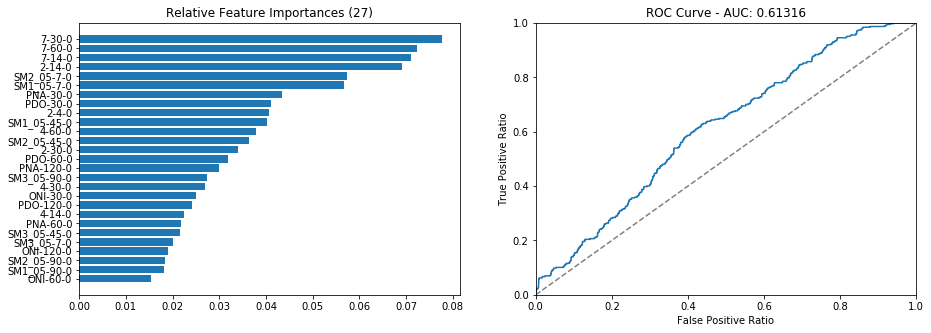

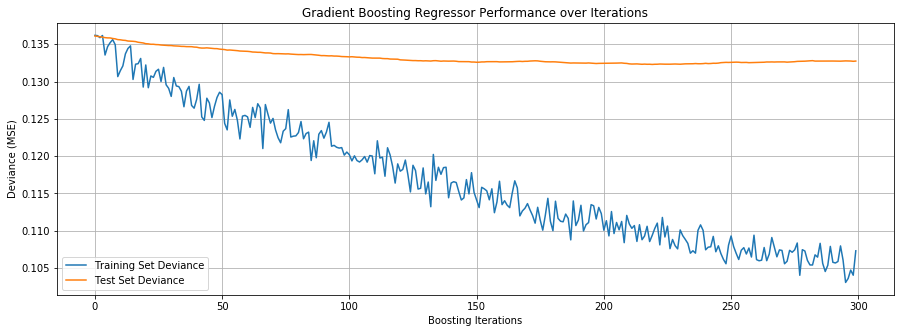

[10] AUC: 0.610 ± 0.004, MSE: 13.301% ± 0.034%

In [428]:
PRECURSOR = 15
LAG = 50

labels = Labels(binary=True)

features_spatcov = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR)
split_spatcov = TrainTestSplit(features_spatcov, labels)

predictor_spatcov = SpatialCovariancePredictor(split_spatcov)

print(f"Spatial Covariance : AUC {predictor_spatcov.auc:3.3f}, MSE {predictor_spatcov.mse:3.3f}")
print(f"  AUC {np.mean(predictor_spatcov.scores['auc']):3.3f} +/- {np.std(predictor_spatcov.scores['auc']):3.3f}")
print(f"  MSE {np.mean(predictor_spatcov.scores['mse']):3.3f} +/- {np.std(predictor_spatcov.scores['mse']):3.3f}")

selection = {
    'SM1_05': ([7, 45, 90], [0]*10),   # Soil Moisture (1)
    'SM2_05': ([7, 45, 90], [0]*10),   # Soil Moisture (2)
    'SM3_05': ([7, 45, 90], [0]*10),   # Soil Moisture (3)
    'PDO': ([30, 60, 120], [0]*10),    # Pacific Decedal Oscillation
    'ONI': ([30, 60, 120], [0]*10),    # El Niño 3.4 Index
    'PNA': ([30, 60, 120], [0]*10),    # Pacific North American
}
      
era_precursor_table = {
    0: {'nina': '2', 'carribean': '6', 'pep': '4', 'lakes': '3'},
    5: {'nina': '2', 'carribean': '4', 'pep': '5', 'lakes': '3'},
    15: {'nina': '2', 'carribean': '4', 'pep': '6', 'lakes': '5', 'nina2': '3'},
    30: {'nina': '2', 'carribean': '4', 'pep': '5', 'nina2': '3'},
    50: {'nina': '2', 'carribean': '3', 'nina2': '4'},
}

# ERA-Interim Selection
if ERA == 'ERA':
      if 'nina' in era_precursor_table[PRECURSOR]:
          selection.update({era_precursor_table[PRECURSOR]['nina']: ([4, 7, 14, 30], [0]*10)})
      if 'nina2' in era_precursor_table[PRECURSOR]:
          selection.update({era_precursor_table[PRECURSOR]['nina2']: ([4, 7, 14, 30], [0]*10)})
      if 'carribean' in era_precursor_table[PRECURSOR]:
          selection.update({era_precursor_table[PRECURSOR]['carribean']: ([4, 7, 14, 30], [0]*10)})
#       if 'pep' in era_precursor_table[PRECURSOR]:
#           selection.update({era_precursor_table[PRECURSOR]['pep']: ([4, 7, 14, 30], [0]*10)})
      if 'lakes' in era_precursor_table[PRECURSOR]:
          selection.update({era_precursor_table[PRECURSOR]['lakes']: ([4, 7, 14, 30], [0]*10)})
    
if ERA == 'ERA5':
    selection.update({
        '2': ([4, 14, 30], [0]*10),   # East Pacific (La Niña?)
        '7': ([14, 30, 60], [0]*10),      # Carribean
        '4': ([14, 30, 60], [0]*10),      # Great Lakes
        
    })

# Load Labels
labels = Labels(binary=True)

# Load Features
features = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR, selection=selection)

# Perform Train/Test Split
split = TrainTestSplit(features, labels, 0)

# Prediction Pipeline (for Each Fold)
def predict(year: int, train_X: pd.DataFrame, train_y: pd.DataFrame, test_X: pd.DataFrame, test_y: pd.DataFrame) -> Tuple[GradientBoostingRegressor, np.ndarray]:
    regressor = GradientBoostingRegressor(
        max_depth=3,
        learning_rate=0.005,
        n_estimators=300,
        max_features='log2',
        subsample=0.5)
    regressor.fit(train_X, train_y.values.ravel())
    return regressor, pd.DataFrame(regressor.predict(test_X), index=test_y.index)

# Machine Learning
predictor = Predictor(split, predict)

print(f"Gradient Boosting  : AUC {predictor.auc:3.3f}, MSE {predictor.mse:3.3f}")
print(f"  AUC {np.mean(predictor.scores['auc']):3.3f} +/- {np.std(predictor.scores['auc']):3.3f}")
print(f"  MSE {np.mean(predictor.scores['mse']):3.3f} +/- {np.std(predictor.scores['mse']):3.3f}")

# Plot Importances & ROC Curve
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(121);
importances = predictor.plot_importances()
plt.subplot(122);
predictor.plot_roc()
plt.show()

# Deviance Curve
predictor.plot_deviance()
plt.show()

auc, mse = [], []

for i in range(10):
    predictor = Predictor(split, predict)
    auc.append(predictor.auc); mse.append(predictor.mse)
    print(f"\r[{i+1:2d}] AUC: {np.mean(auc):3.3f} ± {np.std(auc):3.3f}, MSE: {np.mean(mse):3.3%} ± {np.std(mse):3.3%}", end="")

# Visual Analysis

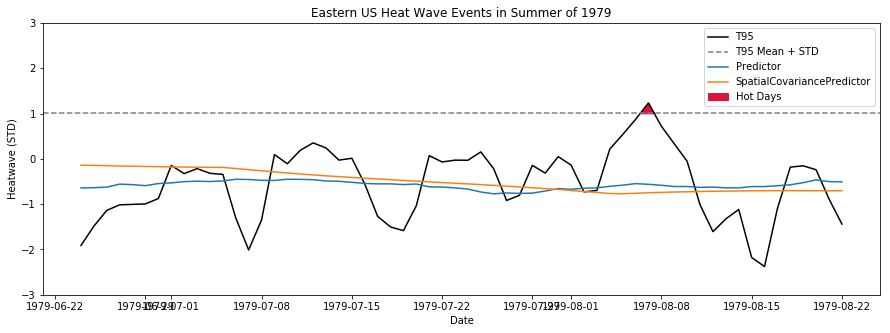

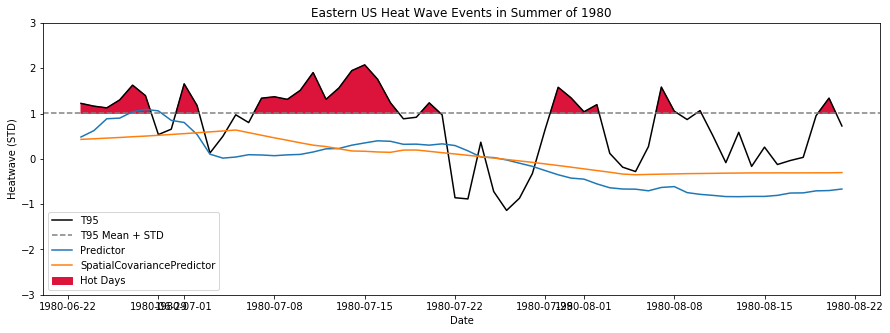

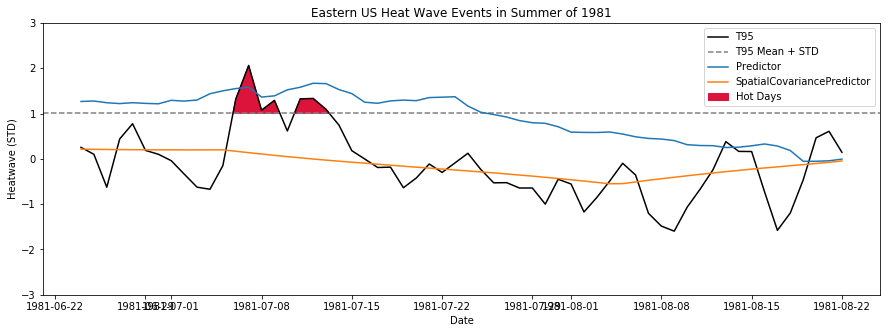

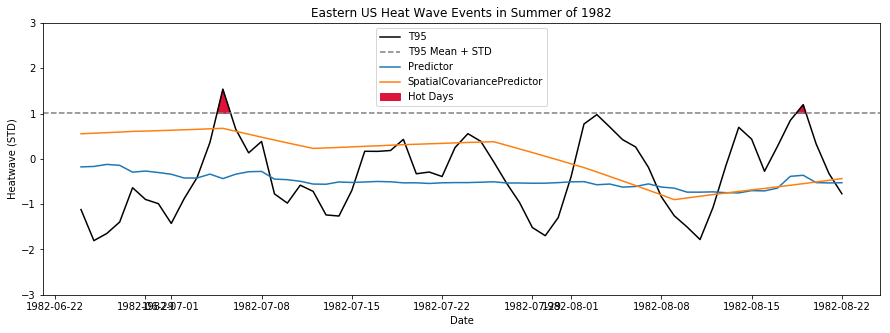

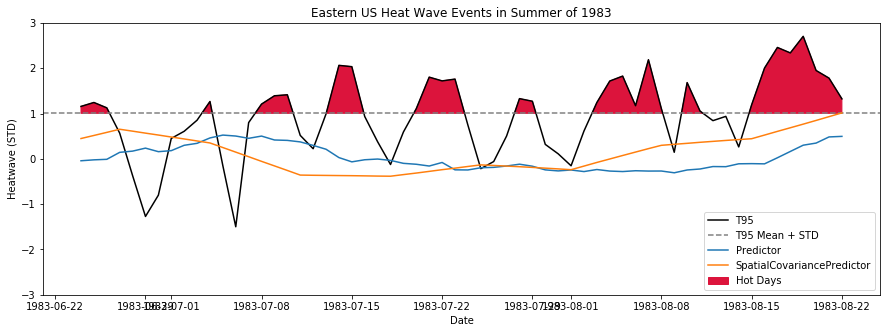

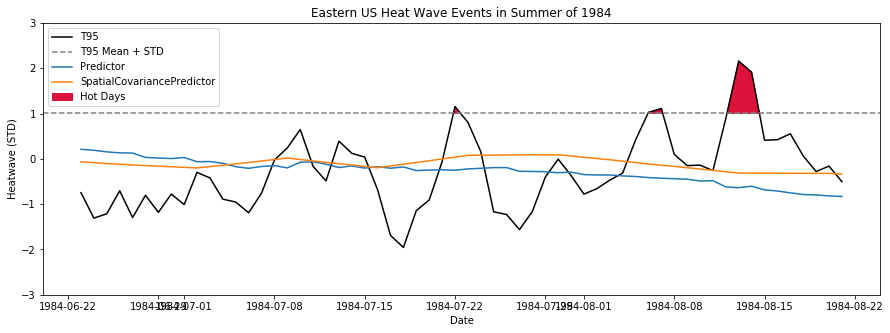

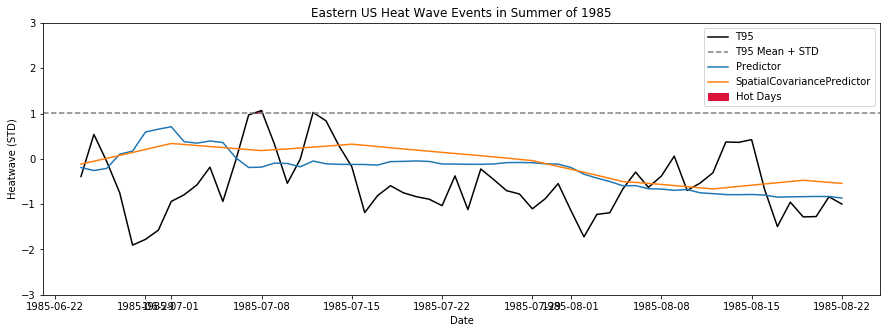

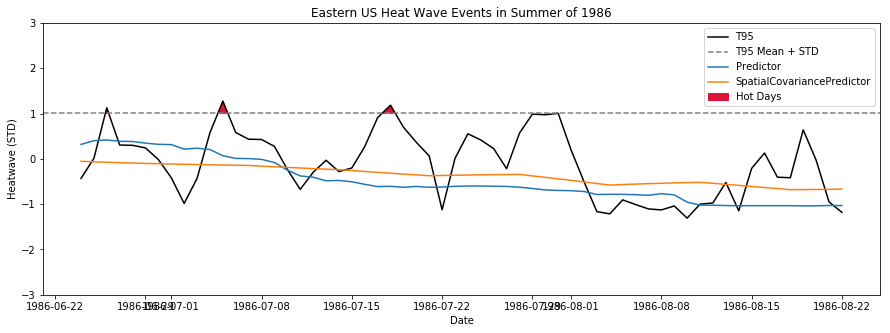

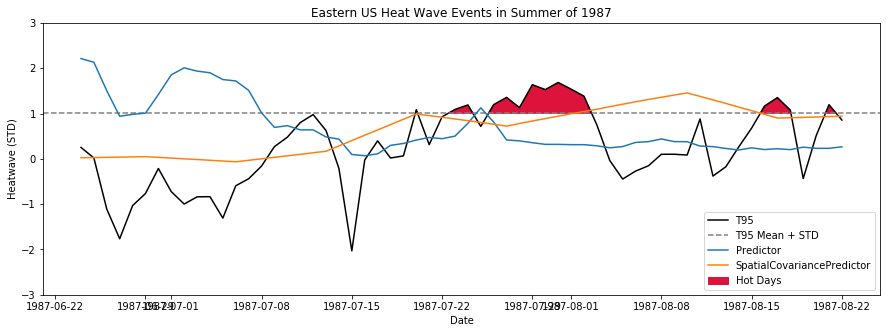

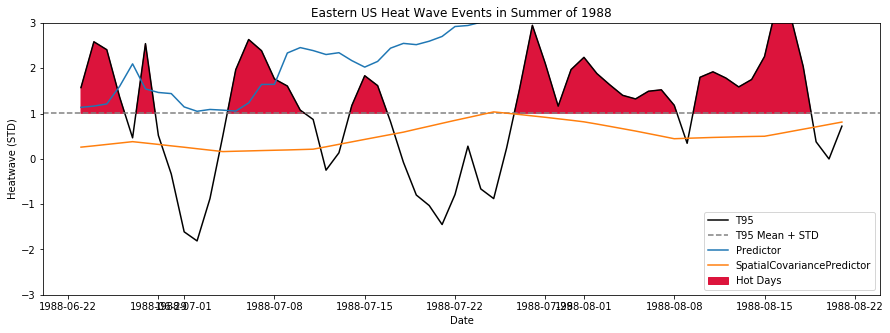

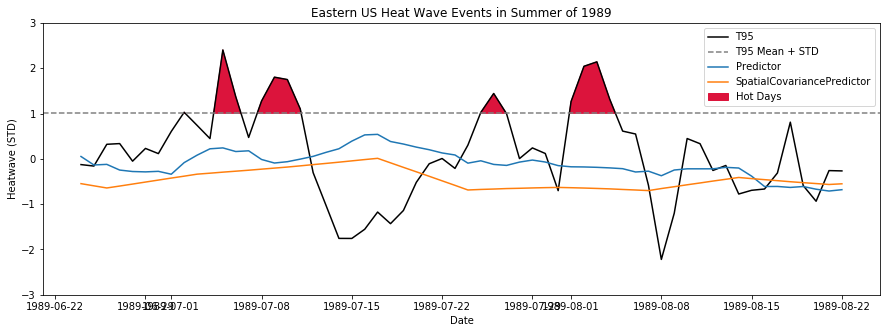

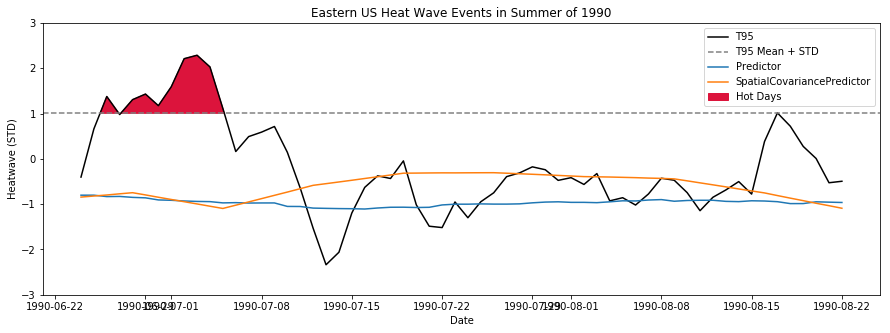

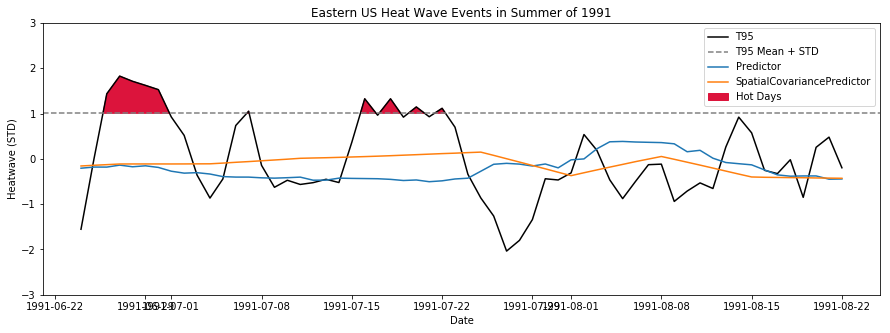

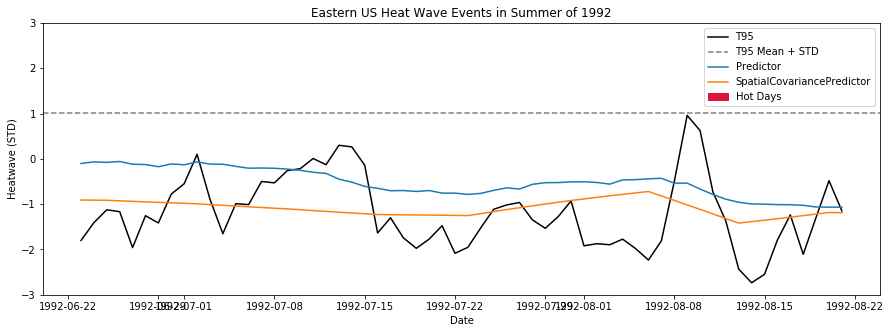

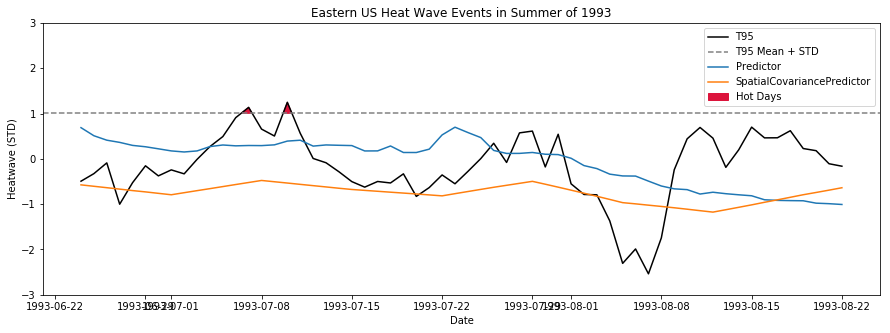

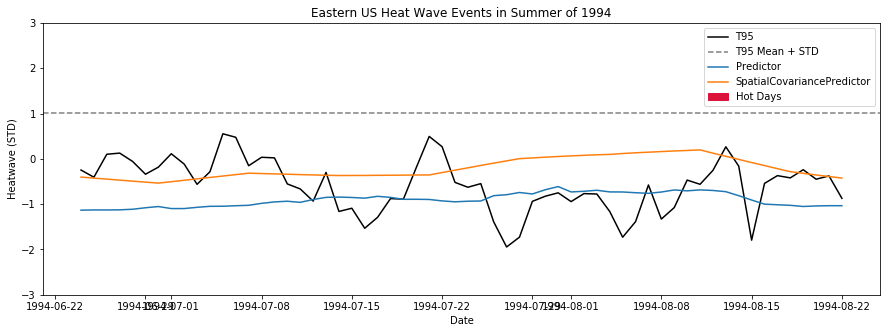

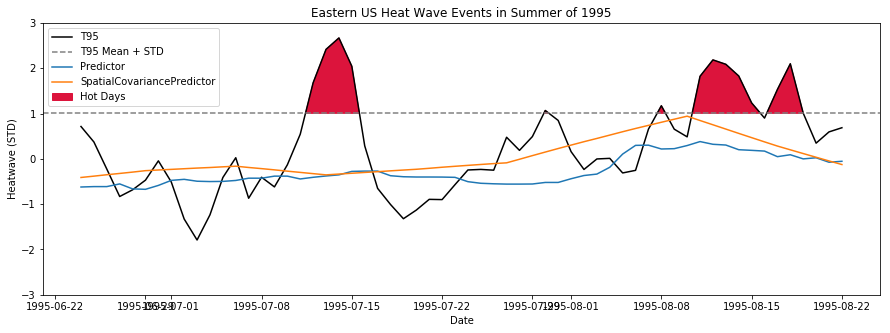

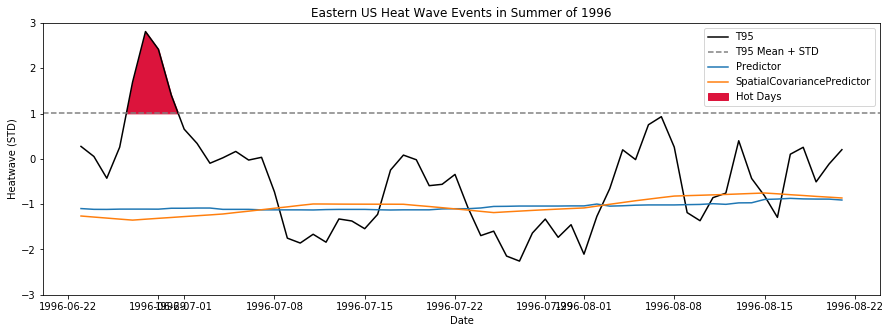

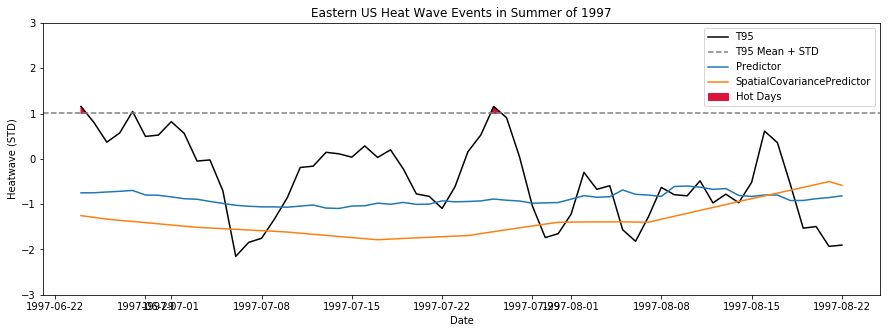

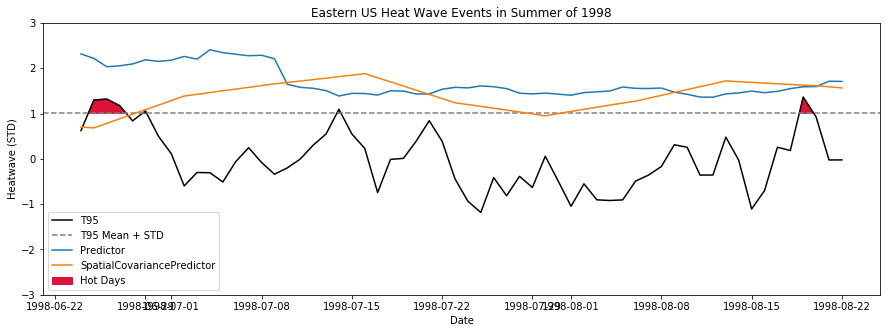

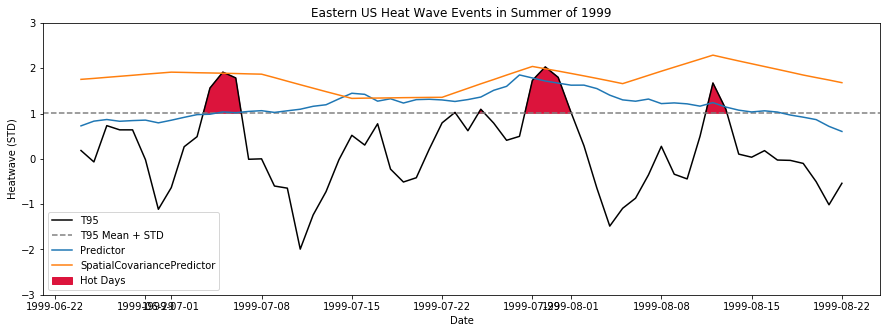

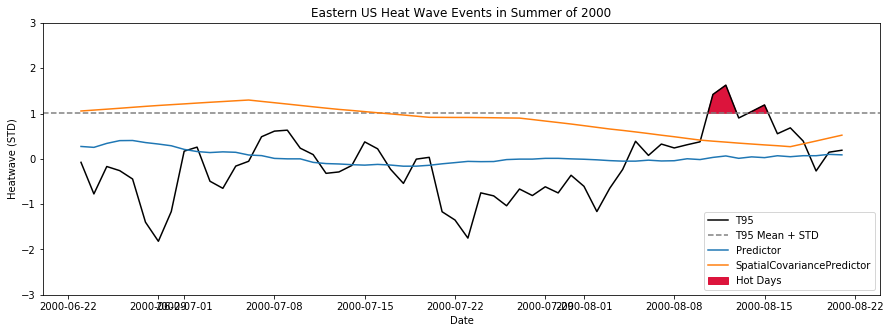

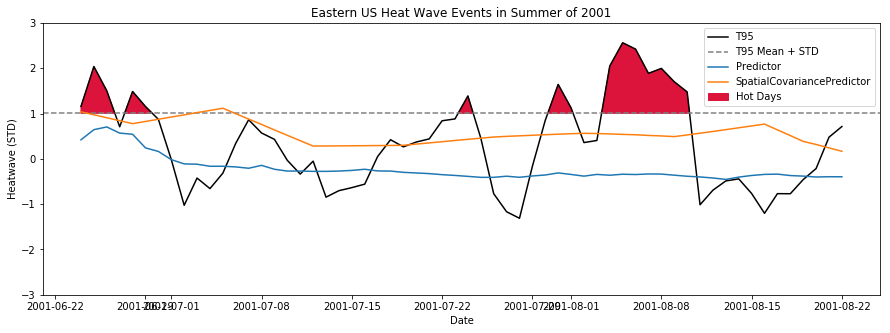

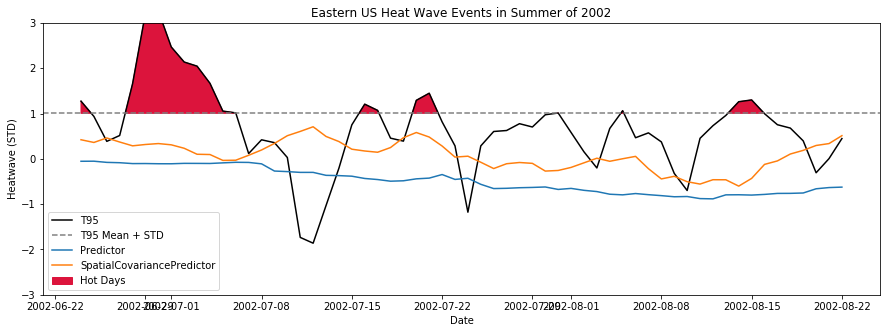

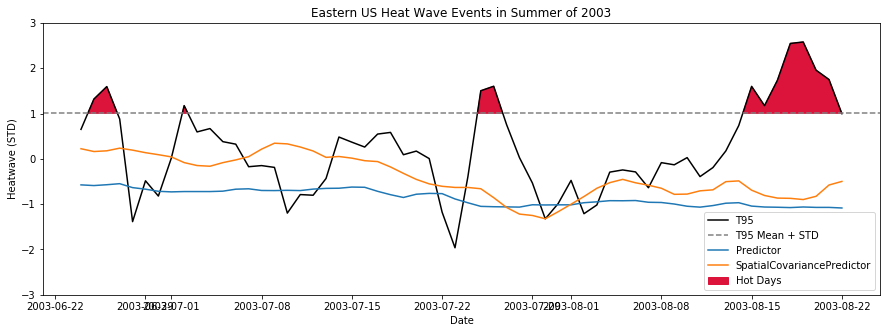

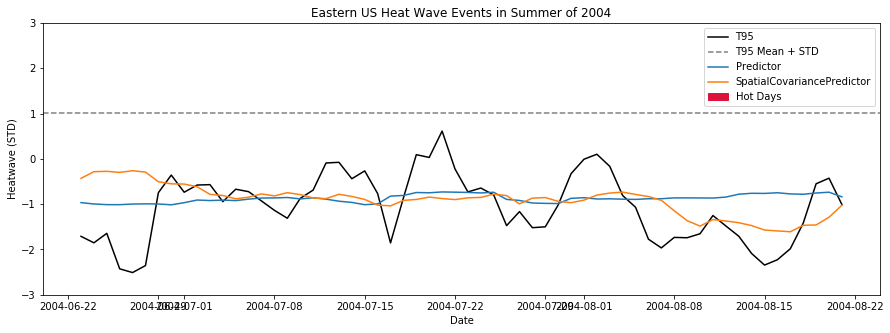

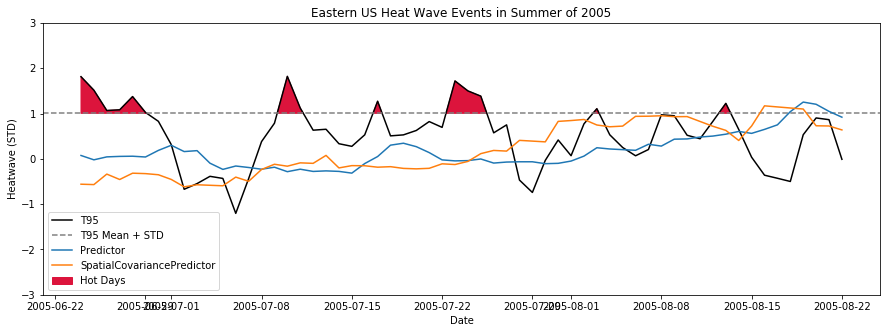

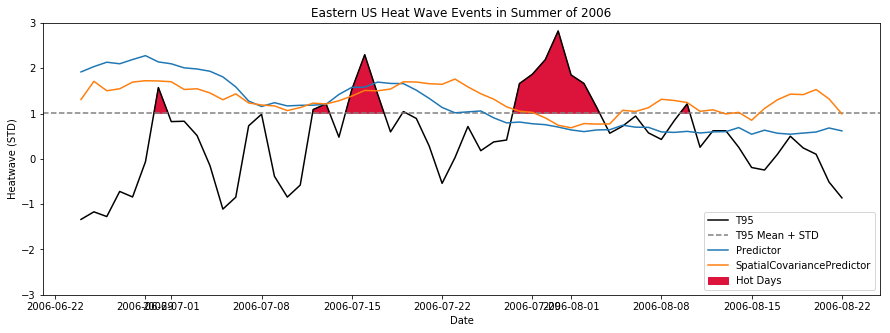

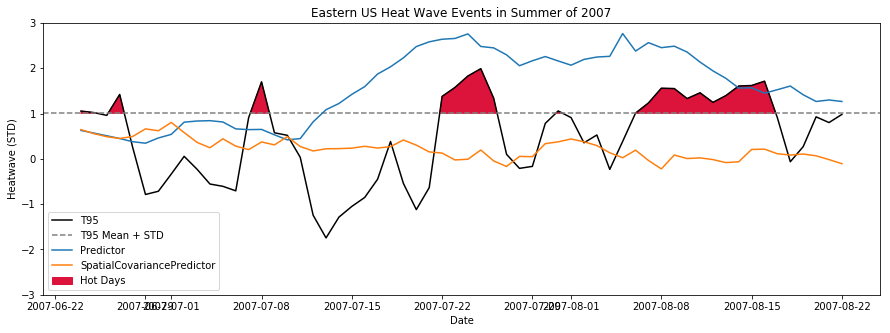

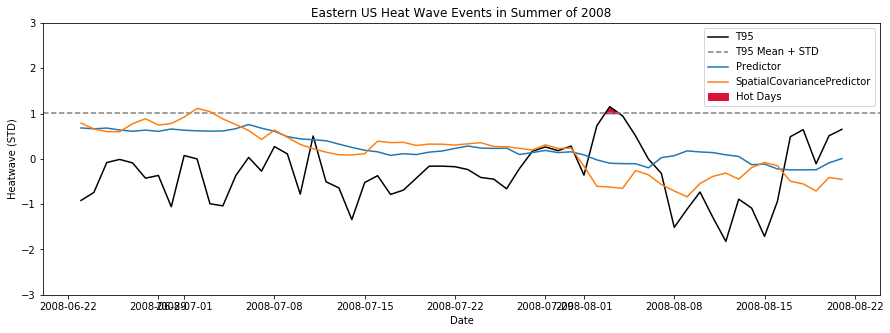

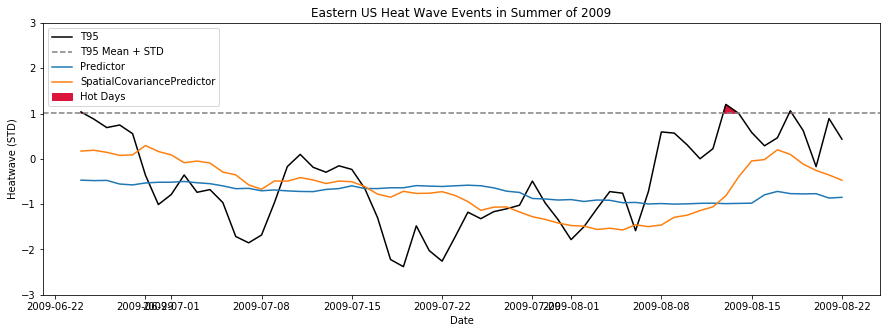

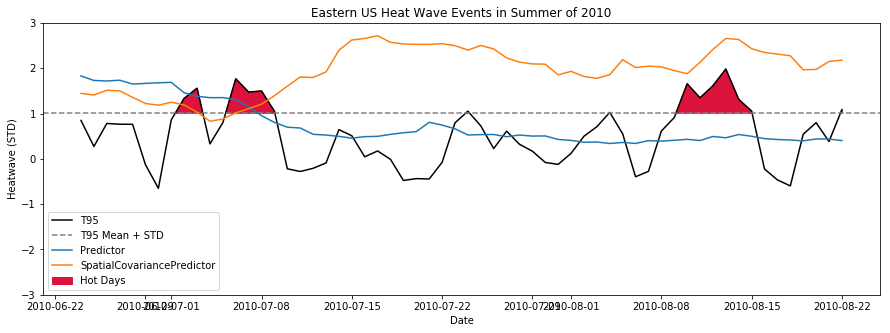

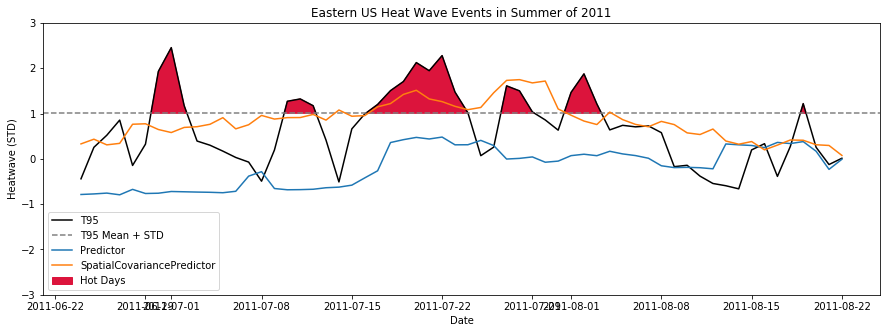

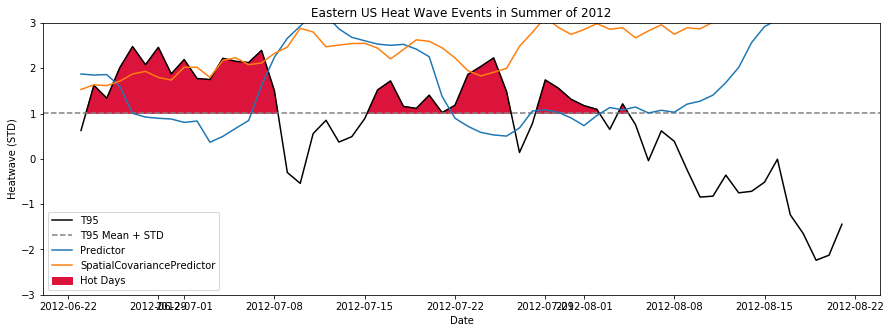

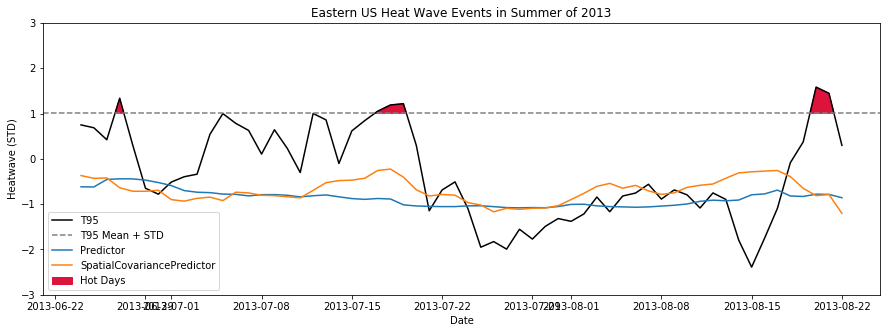

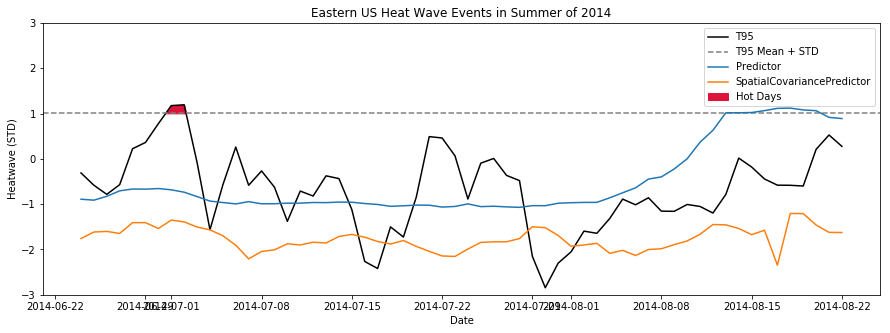

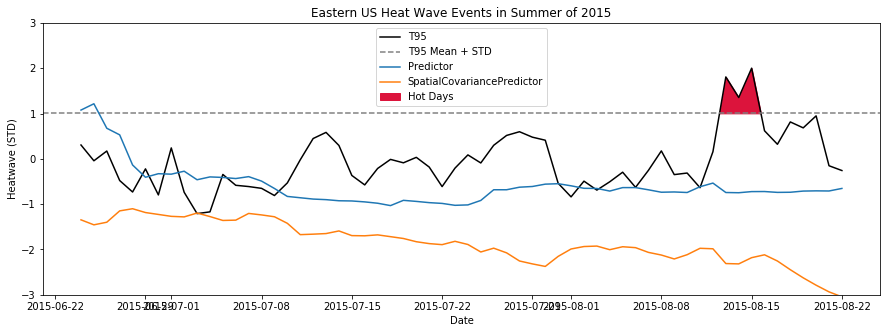

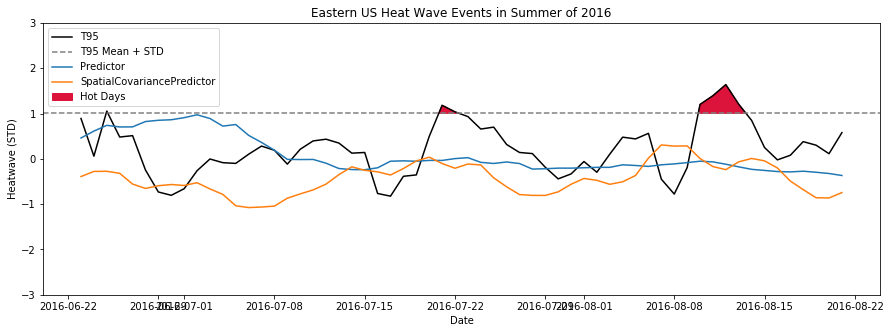

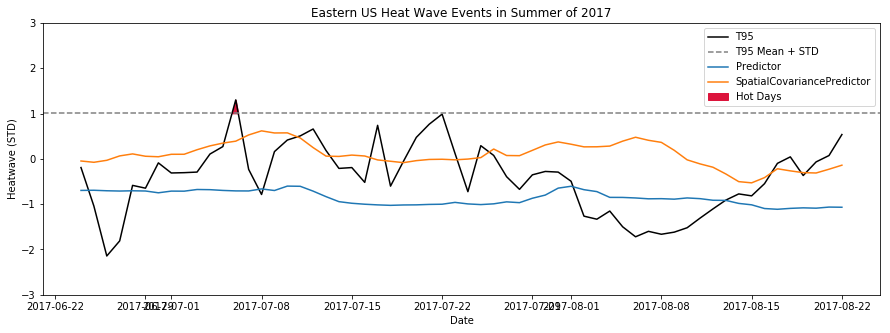

In [391]:
labels = Labels()

for YEAR in labels.years:
    labels.plot(YEAR)
    predictor.plot(YEAR)
    predictor_spatcov.plot(YEAR)
    plt.legend()
    plt.show()